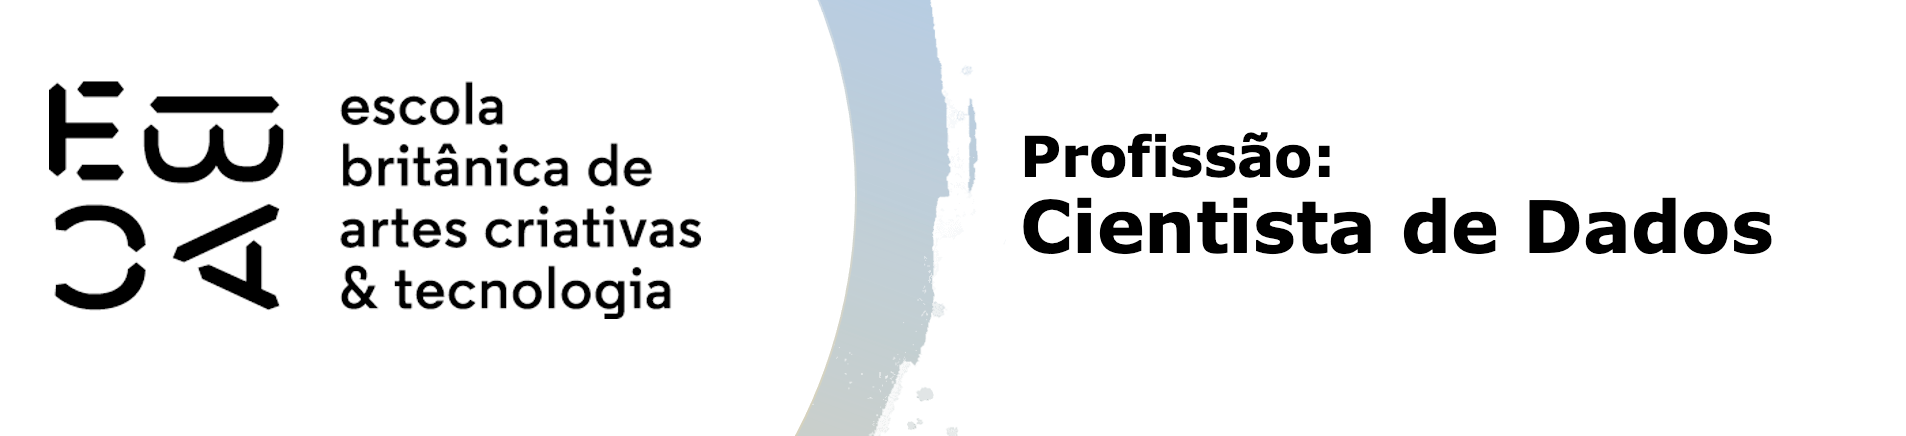

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle('base_nfp.pkl')
# Filtrando apenas dados de 2020 para frente por orientação do professor, para dados mais consistentes
df = df[df['Ano']>=2020]
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

### Criando as colunas que contem as datas especificas

In [3]:
# Criando variável para entender a questão das datas
df_data = df.copy()

# Removendo algumas linhas que não serão usadas, não vejo utilidades nelas para o calculo, deixe comentário caso eu esteja errado por favor
df_data = df.drop(columns = ["CNPJ emit.", "Emitente", "No."])

# Criando a coluna com o dia da semana, domingo, segunda, terça...
df_data['Dia da Semana'] = df_data['Data Emissão'].dt.day_name()

# Criando a coluna final de semana, 1 para final de semana e 0 para outros dias
df_data['Final de Semana'] = df_data['Dia da Semana'].apply(lambda x:1 if x in ['Sunday', 'Saturday'] else 0)

# Criando a coluna dia
df_data['Dia do Mês'] = df_data['Data Emissão'].dt.day

# Criando a coluna mês
df_data['Mês'] = df_data['Data Emissão'].dt.month

# Criando a coluna ano
df_data['Ano'] = df_data['Data Emissão'].dt.year

# Criando a coluna trimestre
df_data['Trimestre'] = df_data['Data Emissão'].dt.quarter

df_data[['Data Emissão', 'Dia da Semana', 'Final de Semana', 'Dia do Mês', 'Mês', 'Ano', 'Trimestre']]

,Data Emissão,Dia da Semana,Final de Semana,Dia do Mês,Mês,Ano,Trimestre
100702,2020-06-30,Tuesday,0,30,6,2020,2
100703,2020-06-30,Tuesday,0,30,6,2020,2
100704,2020-06-30,Tuesday,0,30,6,2020,2
100705,2020-06-30,Tuesday,0,30,6,2020,2
100706,2020-06-30,Tuesday,0,30,6,2020,2
...,...,...,...,...,...,...,...
187641,2021-01-07,Thursday,0,7,1,2021,1
187642,2021-01-07,Thursday,0,7,1,2021,1
187643,2021-01-07,Thursday,0,7,1,2021,1
187644,2021-01-07,Thursday,0,7,1,2021,1


### Criando as colunas que contem os quantis pedidos

In [4]:
df_data['q_5'] = pd.qcut(df['Valor NF'], q=5)
df_data['q_10'] = pd.qcut(df['Valor NF'], q=10)
df_data['q_20'] = pd.qcut(df['Valor NF'], q=20)
df_data['q_50'] = pd.qcut(df['Valor NF'], q=50)
df_data

,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Dia da Semana,Final de Semana,Dia do Mês,Mês,Trimestre,q_5,q_10,q_20,q_50
100702,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia,Tuesday,0,30,6,2,"(90.82, 193.25]","(128.43, 193.25]","(155.2, 193.25]","(176.5, 193.25]"
100703,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido,Tuesday,0,30,6,2,"(49.05, 90.82]","(49.05, 66.21]","(56.9, 66.21]","(62.1, 66.21]"
100704,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido,Tuesday,0,30,6,2,"(193.25, 562500.0]","(346.987, 562500.0]","(346.987, 553.33]","(346.987, 406.824]"
100705,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia,Tuesday,0,30,6,2,"(49.05, 90.82]","(49.05, 66.21]","(49.05, 56.9]","(51.7, 55.04]"
100706,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo,Tuesday,0,30,6,2,"(24.046, 49.05]","(24.046, 35.479]","(29.8, 35.479]","(30.63, 32.99]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,2021-01-07,252.84,2021-01-07,0.0,Liberado,2021,2,0.0,0,não definido,Thursday,0,7,1,1,"(193.25, 562500.0]","(193.25, 346.987]","(250.186, 346.987]","(238.07, 266.199]"
187642,2021-01-07,373.65,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado,Thursday,0,7,1,1,"(193.25, 562500.0]","(346.987, 562500.0]","(346.987, 553.33]","(346.987, 406.824]"
187643,2021-01-07,130.71,2021-01-07,0.0,Liberado,2021,2,0.0,0,Farmácia,Thursday,0,7,1,1,"(90.82, 193.25]","(128.43, 193.25]","(128.43, 155.2]","(128.43, 138.529]"
187644,2021-01-07,43.16,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado,Thursday,0,7,1,1,"(24.046, 49.05]","(35.479, 49.05]","(41.57, 49.05]","(42.99, 45.91]"


### Foi criado as contagens de cada coluna relacionada ao tempo, apenas com as linhas que contem as créditos.

In [5]:
df_creditos = df_data[df_data['Créditos']>0]


count_dia_da_semana = df_creditos['Dia da Semana'].value_counts()
count_dia_do_mes = df_creditos['Dia do Mês'].value_counts()
count_mes = df_creditos['Mês'].value_counts()
count_trimestre = df_creditos['Trimestre'].value_counts()


count_final_de_semana = df_creditos['Final de Semana'].value_counts()
# Aqui eu dividi a contagem pelo número de dias da semana e final de semana para
# ficar uma comparação proporcional
count_final_de_semana[0] = count_final_de_semana[0]/5
count_final_de_semana[1] = count_final_de_semana[1]/2

### O gráfico abaixo mostra as contagens, não foi visto nenhuma caracteristica marcante, apenas que no final de ano e começo de ano tem um aumento e que no sábado também tem um leve aumento de notas com crédito, mas isso já é esperado porque também tem um maior gasto em geral.

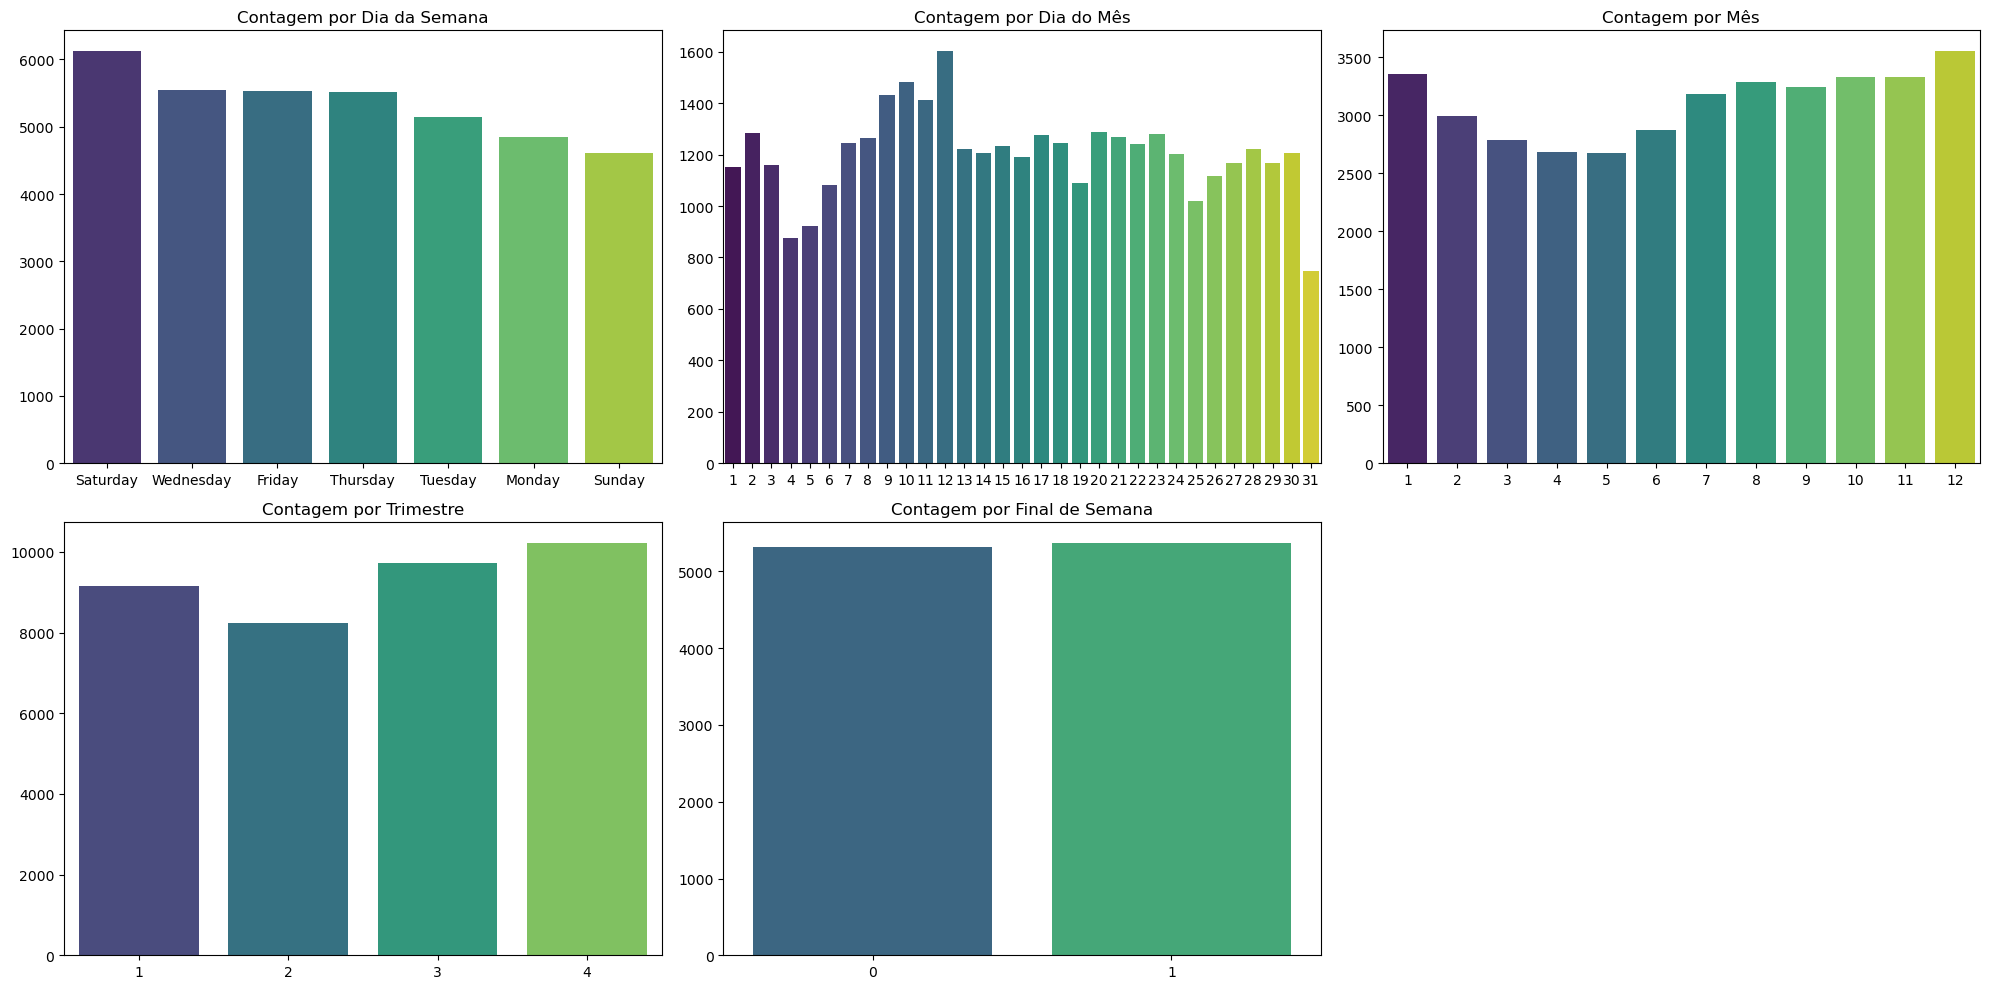

In [6]:
# Definindo a quantidade de subplots
plt.figure(figsize=(20, 10))

# Plot para Dia da Semana
plt.subplot(2, 3, 1)  # 2 linhas, 3 colunas, plot 1
sns.barplot(x=count_dia_da_semana.index, y=count_dia_da_semana.values, palette='viridis')
plt.title('Contagem por Dia da Semana')

# Plot para Dia do Mês
plt.subplot(2, 3, 2)  # 2 linhas, 3 colunas, plot 2
sns.barplot(x=count_dia_do_mes.index, y=count_dia_do_mes.values, palette='viridis')
plt.title('Contagem por Dia do Mês')

# Plot para Mês
plt.subplot(2, 3, 3)  # 2 linhas, 3 colunas, plot 3
sns.barplot(x=count_mes.index, y=count_mes.values, palette='viridis')
plt.title('Contagem por Mês')

# Plot para Trimestre
plt.subplot(2, 3, 4)  # 2 linhas, 3 colunas, plot 4
sns.barplot(x=count_trimestre.index, y=count_trimestre.values, palette='viridis')
plt.title('Contagem por Trimestre')

# Plot para Final de Semana
plt.subplot(2, 3, 5)  # 2 linhas, 3 colunas, plot 5
sns.barplot(x=count_final_de_semana.index, y=count_final_de_semana.values, palette='viridis')
plt.title('Contagem por Final de Semana')

# Ajustando o layout para evitar sobreposição de títulos
plt.tight_layout()

# Exibir os gráficos
plt.show()

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

#### Não foi usado o DataFrame criado df_data por conter muitas colunas baseadas em colunas já existentes e essas colunas já estarem com a quebra em quantis aplicados, isso iria atrapalhar o calculo e podendo levar a uma situação de multicolinearidade.

#### Como as colunas Data Emissão e Data registro tem muitas categorias e além disso são do tipo datetime, para usar o qcut e dividir em quantis será necessário fazer uma transformação nessas colunas para ficar numéricas.
<br>

#### Para isso será calculado a quantidade de dias passados desde o registro mais antigo, simulando que o registro mais antigo seria o inicio desse sistema.

In [7]:
# Criando DF para guardar os valores de Information Value
df_IV = df.copy()
# Removendo as colunas igual no df_data, colunas não relevantes para o calculo
df_IV = df_IV.drop(columns = ["CNPJ emit.", "Emitente", "No."])

# Salvando o minimo da data de cada coluna
dt_emissao_min = df_IV['Data Emissão'].min()
dt_registro_min = df_IV['Data Registro'].min()

# Subtraindo os dias de cada coluna pelo dia mais antigo e salvando essa diferença de dias
df_IV['Data Emissão'] = (df_IV['Data Emissão'] - dt_emissao_min).dt.days
df_IV['Data Registro'] = (df_IV['Data Registro'] - dt_registro_min).dt.days

df_IV

,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100702,181,179.55,181,0.0,Liberado,2020,1,0.0,0,Farmácia
100703,181,63.38,181,0.0,Liberado,2020,1,0.0,0,não definido
100704,181,396.41,181,0.0,Liberado,2020,1,0.0,0,não definido
100705,181,53.90,181,0.0,Liberado,2020,1,0.0,0,Farmácia
100706,181,32.90,181,0.0,Liberado,2020,1,0.0,0,Varejo
...,...,...,...,...,...,...,...,...,...,...
187641,372,252.84,372,0.0,Liberado,2021,2,0.0,0,não definido
187642,372,373.65,372,0.0,Liberado,2021,2,0.0,0,Mercado
187643,372,130.71,372,0.0,Liberado,2021,2,0.0,0,Farmácia
187644,372,43.16,372,0.0,Liberado,2021,2,0.0,0,Mercado


#### Abaixo pode ser visualizado a quantidade de categorias que ficou em cada coluna do DataFrame df_IV, as colunas de Data Emissão e Data Registro agora estão numéricas com a contagem dos dias, além disso os valores da nota fiscal, créditos e retorno tem muitos valores, estão será necessário alterar essas colunas em grupos de valores para trabalhar melhor com o Information Value.

In [8]:
print(f"Quantidade de categorias: \n\n{df_IV.nunique()}\n\n\n")
print(f"Tipo dos dados: \n\n{df_IV.dtypes}")

Quantidade de categorias: 

Data Emissão             731
Valor NF               28381
Data Registro            734
Créditos                7845
Situação do Crédito        2
Ano                        2
Semestre                   2
Retorno                35839
flag_credito               2
categoria                  9
dtype: int64



Tipo dos dados: 

Data Emissão              int64
Valor NF                float64
Data Registro             int64
Créditos                float64
Situação do Crédito    category
Ano                       int64
Semestre                  int64
Retorno                 float64
flag_credito              int64
categoria                object
dtype: object


#### Abaixo foi calculado a correlação entre Data Registro e Data Emissão e visto que as colunas são 99% correlacionadas, indicando apenas que 3 registros são diferentes pela Data Registro como visto na quantidade de categorias acima, então será removido a coluna Data Emissão e deixado apenas a Data Registro.

In [9]:
# Calculando o quão iguais as colunas são usando o método corr() do pandas
correlacao = df_IV['Data Registro'].corr(df_IV['Data Emissão'])
correlacao

0.9961229032816102

In [10]:
# Removendo a coluna Data Emissão pois a Data Registro já tem todos seus dados
df_IV = df_IV.drop(columns = ["Data Emissão"])
df_IV.columns

Index(['Valor NF', 'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano',
       'Semestre', 'Retorno', 'flag_credito', 'categoria'],
      dtype='object')

#### Acreditei que esse DataFrame já estava pré arrumado evitando alguns problemas como valores nulos, porém a ver que tem duas colunas praticamente identicas, resolvi averiguar e foi encontrado 956 linhas nulas em Retorno, acredito que os valores nulos provavelmente são valores sem retorno, então vou substitui-los por zero.

In [11]:
# Fazendo contagem de valores nulos
df_IV.isnull().sum()

Valor NF                 0
Data Registro            0
Créditos                 0
Situação do Crédito      0
Ano                      0
Semestre                 0
Retorno                956
flag_credito             0
categoria                0
dtype: int64

In [12]:
linhas_nulas = df_IV.isnull().any(axis=1) # Criado uma mascara True False para nulos
df_nulo = df_IV[linhas_nulas] # Criando um novo df apenas com a mascara que tem True (os nulos)
df_nulo

,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100923,0.0,179,0.0,Liberado,2020,1,NaN,0,Varejo
101244,0.0,176,0.0,Liberado,2020,1,NaN,0,Varejo
101451,0.0,175,0.0,Liberado,2020,1,NaN,0,Vestuário
101535,0.0,174,0.0,Liberado,2020,1,NaN,0,Varejo
101542,0.0,174,0.0,Liberado,2020,1,NaN,0,Varejo
...,...,...,...,...,...,...,...,...,...
186231,0.0,676,0.0,Liberado,2021,2,NaN,0,Varejo
187052,0.0,492,0.0,Liberado,2021,2,NaN,0,Varejo
187199,0.0,431,0.0,Liberado,2021,2,NaN,0,Varejo
187200,0.0,431,0.0,Liberado,2021,2,NaN,0,Varejo


In [13]:
# Substituindo os valores nulos por zero, seguindo o formato float como os demais da coluna
df_IV.fillna(0.0, inplace=True)
df_IV.isnull().sum()

Valor NF               0
Data Registro          0
Créditos               0
Situação do Crédito    0
Ano                    0
Semestre               0
Retorno                0
flag_credito           0
categoria              0
dtype: int64

### Discretização

#### O calculo do IV serve para trabalhar com variáveis categóricas, variáveis numéricas tem muitas categorias, cada valor diferente entra no calculo, então toda variável que tem mais de 10 categorias como visto anteriormente pelo df.nunique sera desmenbrado em 10 grupos ou menos (de acordo com a distribuição dos dados).

In [14]:
# Percorrendo todas as colunas, as que tiver mais de 10 categorias será aplicado o qcut
for coluna in df_IV.columns:
    if df_IV[coluna].nunique() > 10:
        df_IV[coluna] = pd.qcut(df_IV[coluna], q = 10, duplicates='drop')
        
df_IV

,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100702,"(128.43, 193.25]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,Farmácia
100703,"(49.05, 66.21]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,não definido
100704,"(346.987, 562500.0]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,não definido
100705,"(49.05, 66.21]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,Farmácia
100706,"(24.046, 35.479]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,Varejo
...,...,...,...,...,...,...,...,...,...
187641,"(193.25, 346.987]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,não definido
187642,"(346.987, 562500.0]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,Mercado
187643,"(128.43, 193.25]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,Farmácia
187644,"(35.479, 49.05]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,Mercado


#### Comparando o antes e depois do QCUT, curioso observar que a coluna Retorno ficou com apenas 5 categorias, sendo que sua distribuição dos dados não permitiu a criação das 10 categorias.

In [15]:
print(f"Quantidade de categorias: \n\n{df_IV.nunique()}\n\n\n")

Quantidade de categorias: 

Valor NF               10
Data Registro          10
Créditos                5
Situação do Crédito     2
Ano                     2
Semestre                2
Retorno                 5
flag_credito            2
categoria               9
dtype: int64





In [16]:
df_IV

,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100702,"(128.43, 193.25]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,Farmácia
100703,"(49.05, 66.21]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,não definido
100704,"(346.987, 562500.0]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,não definido
100705,"(49.05, 66.21]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,Farmácia
100706,"(24.046, 35.479]","(155.0, 233.0]","(-0.001, 0.25]",Liberado,2020,1,"(-0.001, 0.00582]",0,Varejo
...,...,...,...,...,...,...,...,...,...
187641,"(193.25, 346.987]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,não definido
187642,"(346.987, 562500.0]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,Mercado
187643,"(128.43, 193.25]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,Farmácia
187644,"(35.479, 49.05]","(306.0, 377.0]","(-0.001, 0.25]",Liberado,2021,2,"(-0.001, 0.00582]",0,Mercado


#### Para calcular o Information Value será necessário comparar o evento do não evento, ou seja, o valor 1 da coluna flag_credito do valor 0, para isso foi feito dois DataFrames com os respectivos valores e removido a coluna flag_credito para que essa coluna não entre no calculo, já que é a variável que está em foco para calcular o Information Value.

In [17]:
# Separando os flags em de evento e não evento
df_evento = df_IV[df_IV['flag_credito']==1]
df_no_evento = df_IV[df_IV['flag_credito']==0]
# Removendo a variável resposta flag_credito para o calculo do IV não iterar sobre essa coluna
df_IV = df_IV.drop(columns=['flag_credito'])

#### O gráfico abaixo tem dois objetivos, mostrar a proporção dos dados de eventos (nota com crédito positivo) em comparação com não eventos e verificar possíveis problemas nos calculos do Information Value.
<br>

#### Verificando os gráficos é possível notar dois problemas, o primeiro são as colunas Retorno e Créditos que tem várias categorias do DataFrame de Não Eventos zeradas, então ao calcular a razão de chances (evento / não evento) vira uma divisão por zero, além disso a coluna Situação crédito tem uma categoria chamada "A Calcular" que não tem nenhum dado e fica com resultado vazio (NaN).

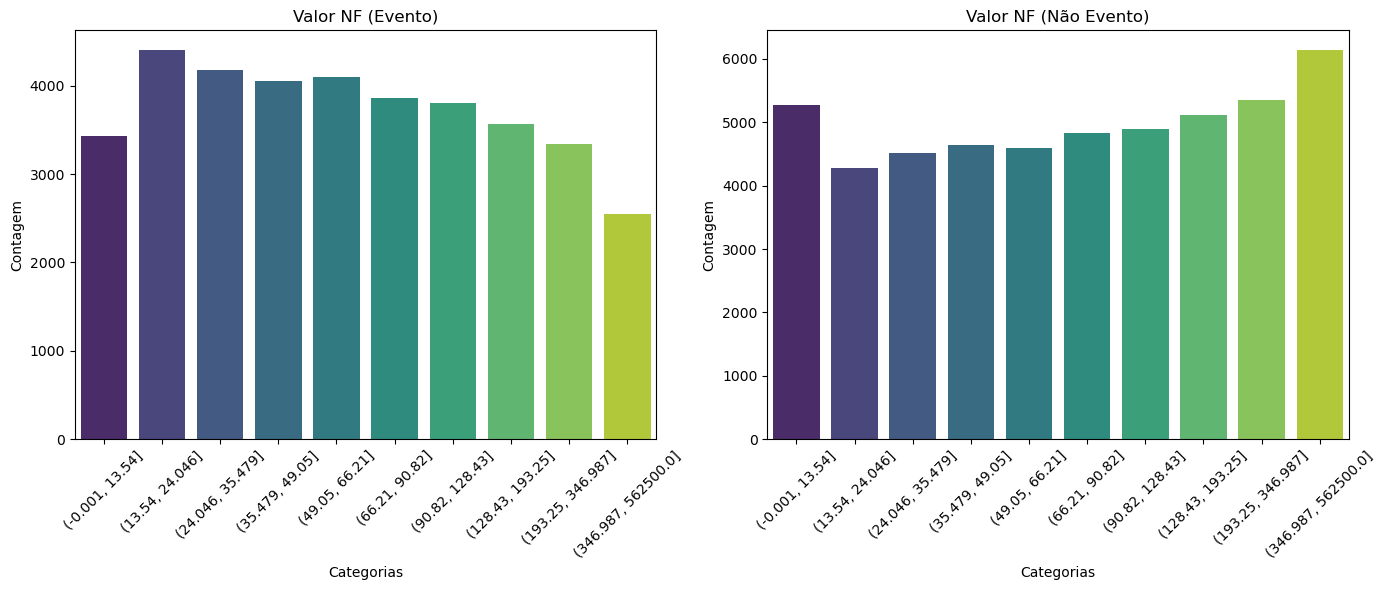

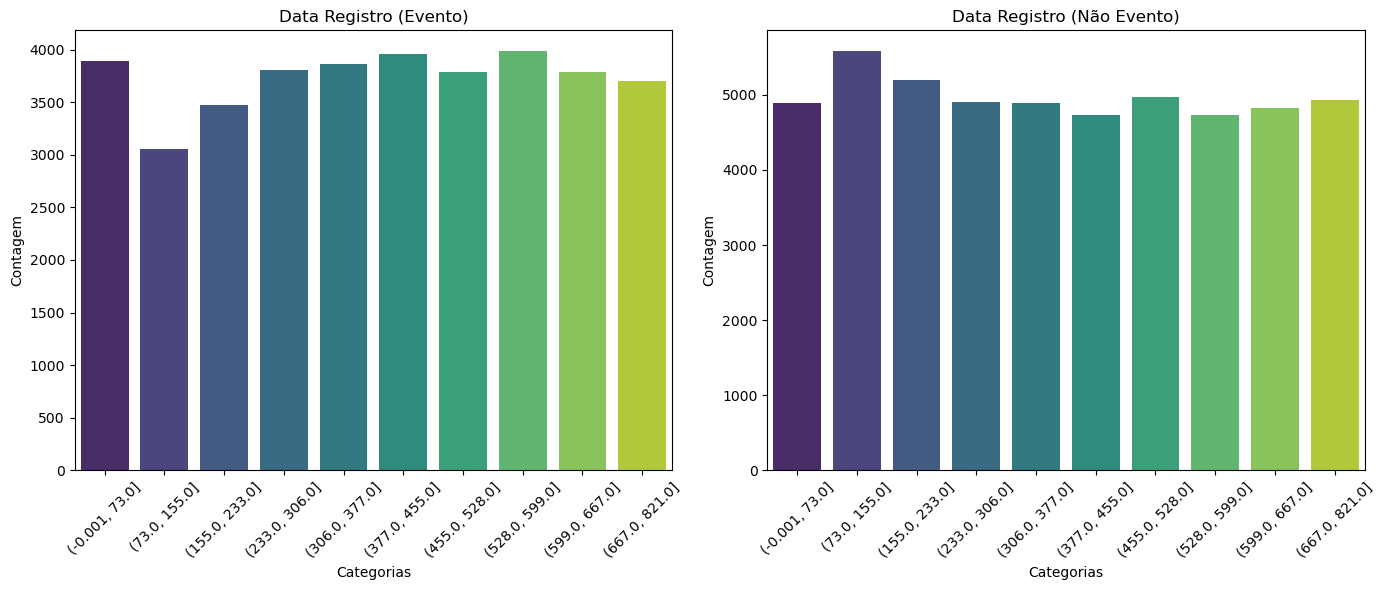

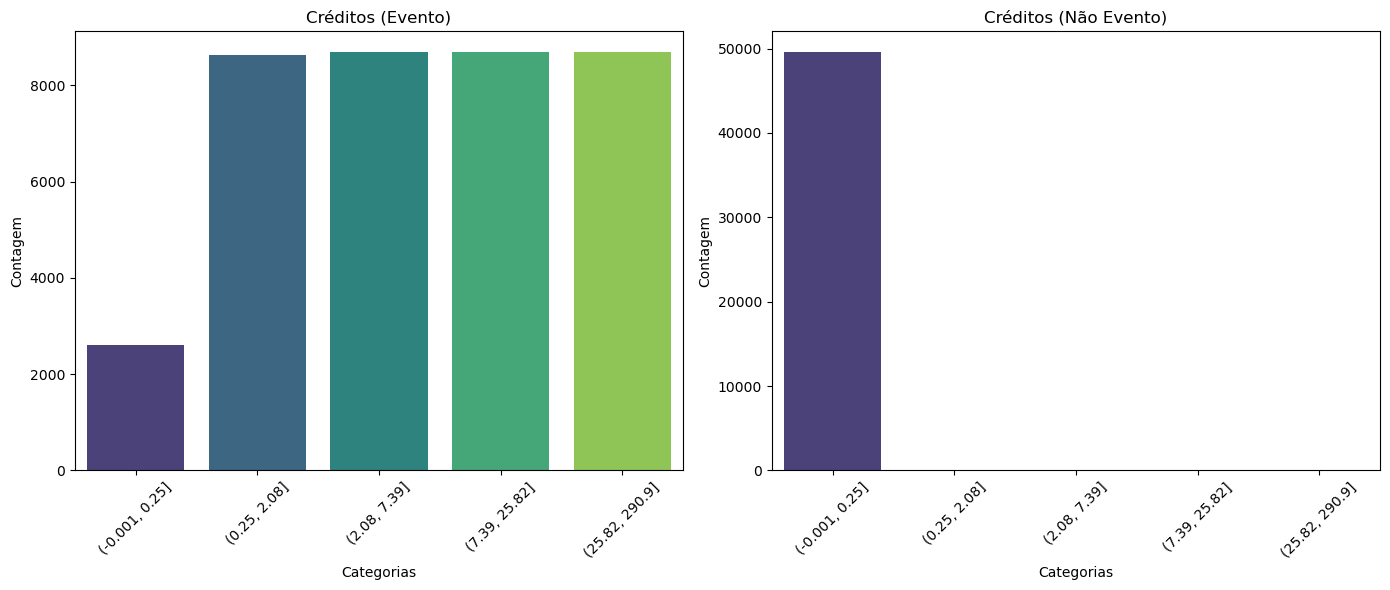

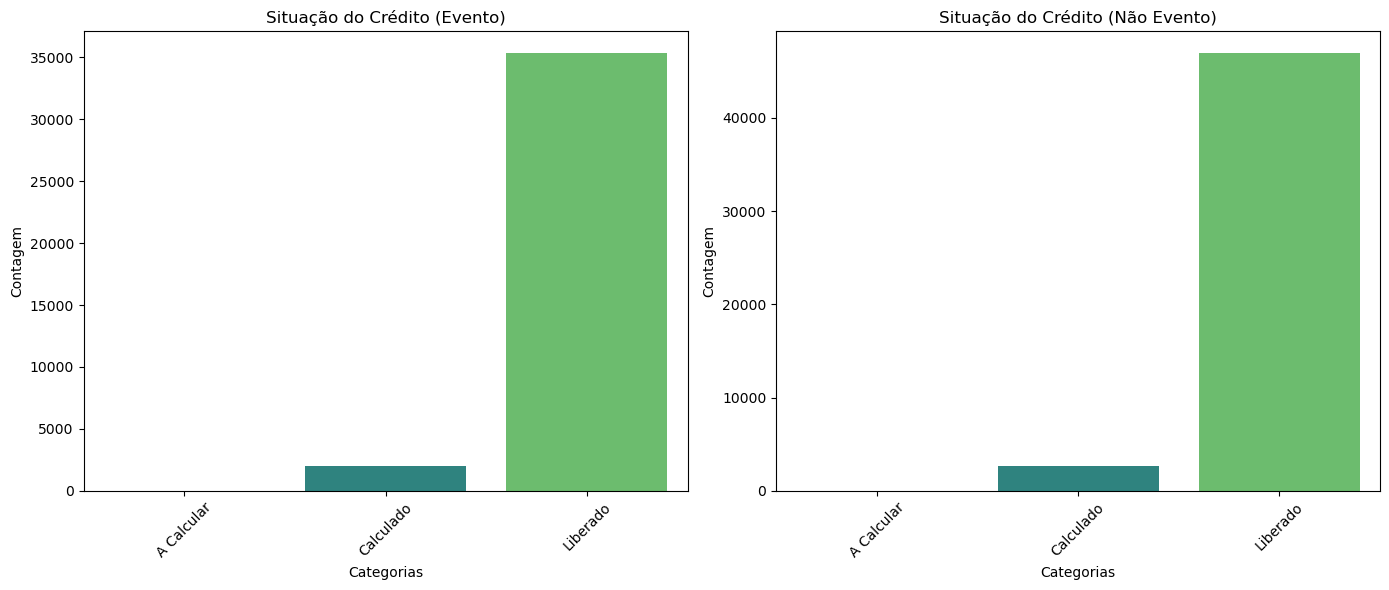

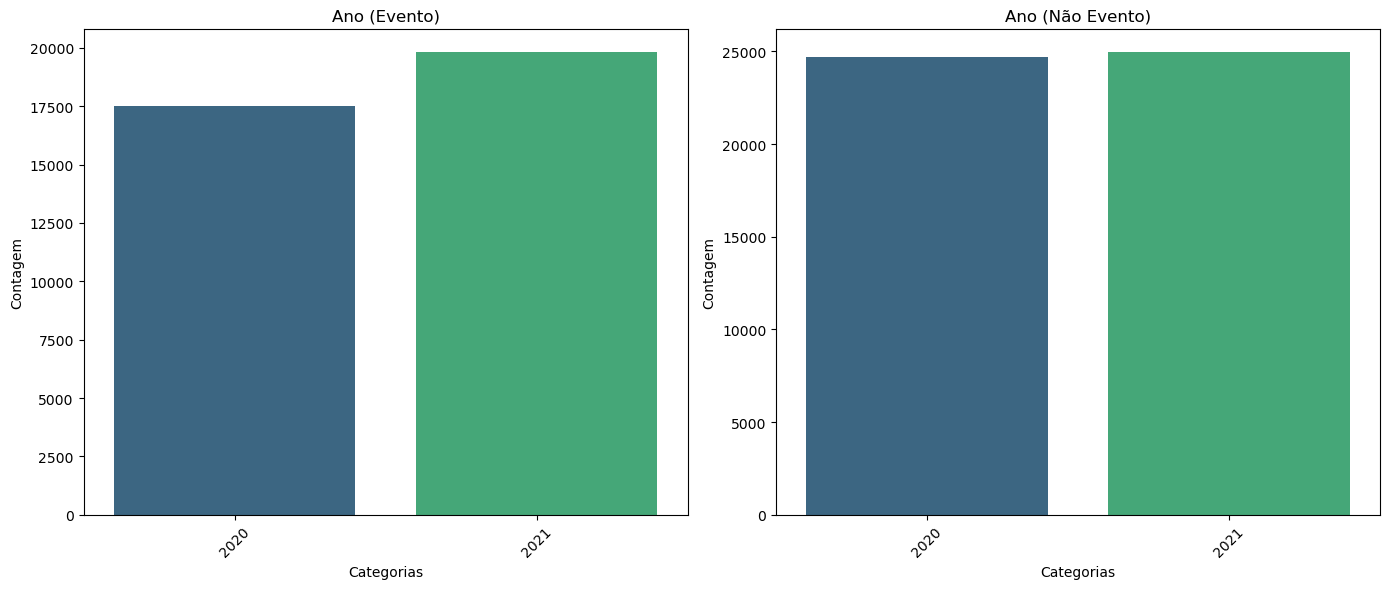

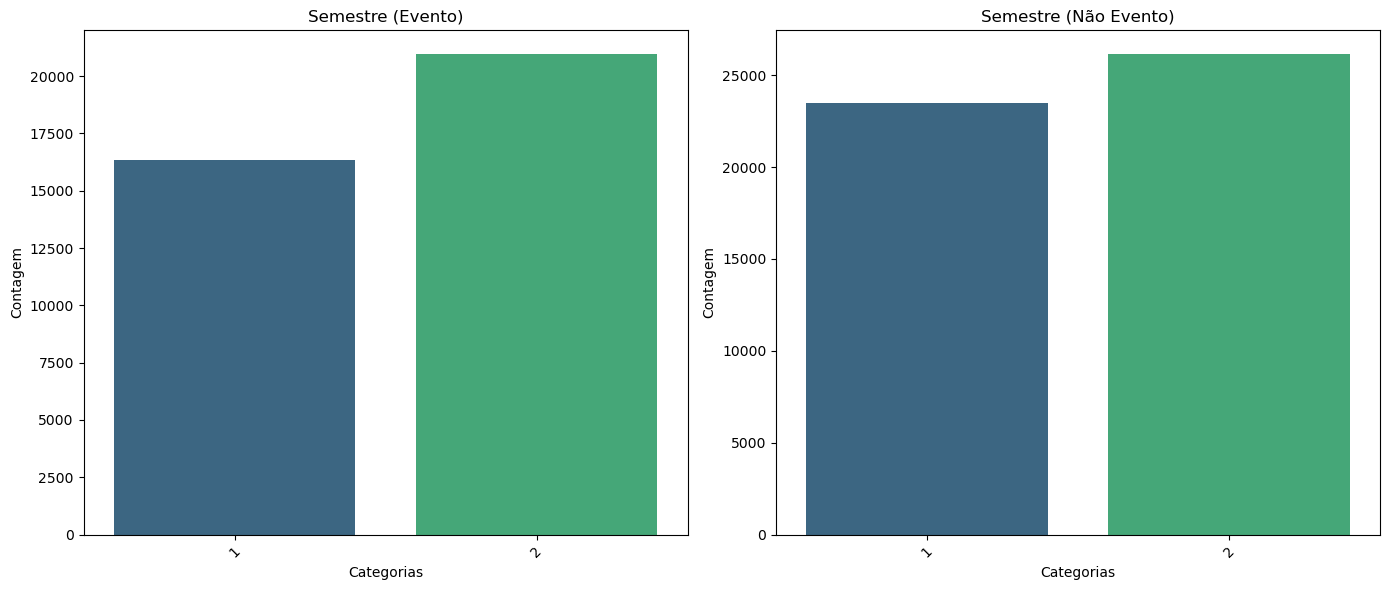

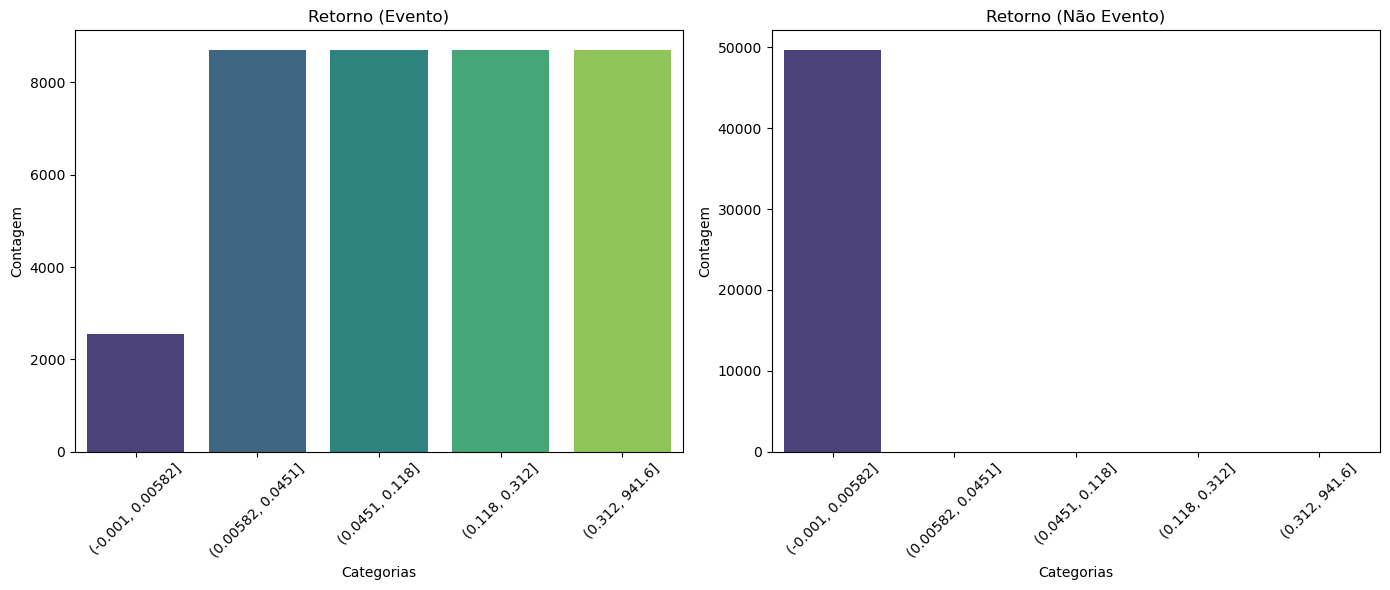

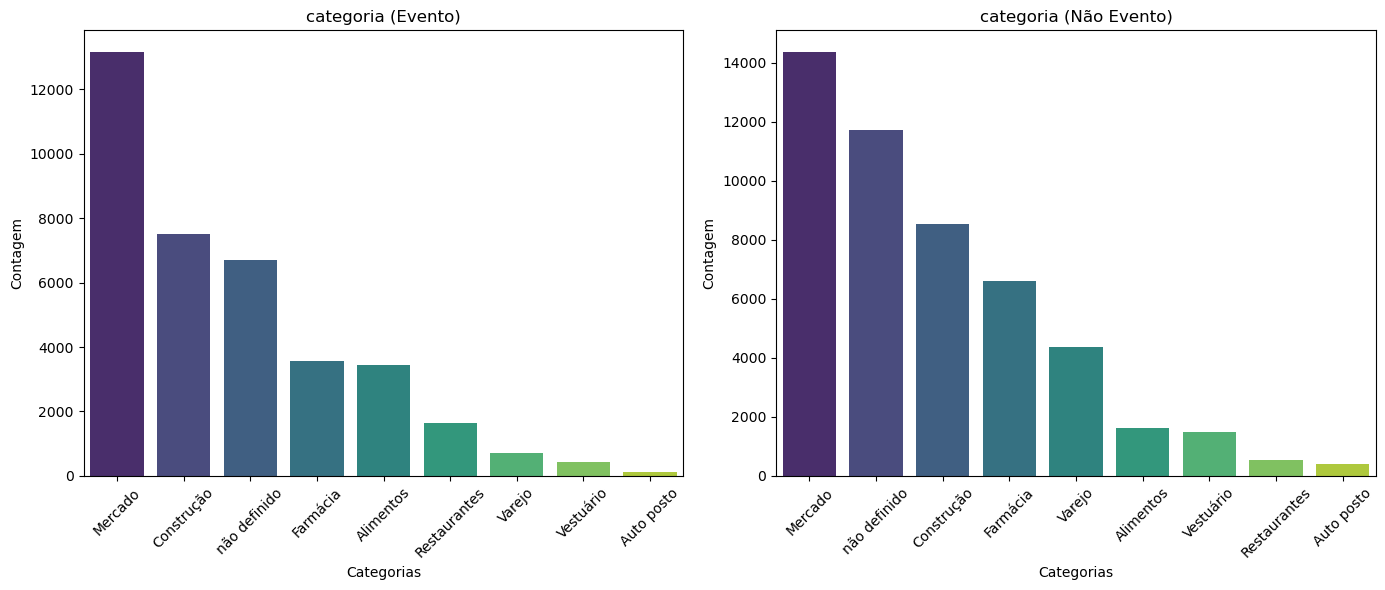

In [18]:
# Looping para iterar sobre todas colunas
for coluna in df_IV.columns:
    # Calcula a contagem das categorias para df_evento
    contagem_categorias_1 = df_evento[coluna].value_counts()

    # Calcula a contagem das categorias para df_no_evento
    contagem_categorias_0 = df_no_evento[coluna].value_counts()

    # Cria os subplots 1 linha com 2 figuras, largura e altura
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    ###########################################################################################
    # Gráfico do tipo barras, ax 0 para a primeira imagem e 1 para a segunda imagem
    sns.barplot(x=contagem_categorias_1.index, y=contagem_categorias_1.values, ax=axes[0], palette="viridis")
    axes[0].set_title(f'{coluna} (Evento)')
    axes[0].set_xlabel('Categorias')
    axes[0].set_ylabel('Contagem')
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=contagem_categorias_0.index, y=contagem_categorias_0.values, ax=axes[1], palette="viridis")
    axes[1].set_title(f'{coluna} (Não Evento)')
    axes[1].set_xlabel('Categorias')
    axes[1].set_ylabel('Contagem')
    axes[1].tick_params(axis='x', rotation=45)
    ###########################################################################################
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    plt.show()

#### Parando para analisar, a categoria "A Calcular" não muda em nada se for removida pois não tem nenhum individuo tanto no evento quanto no não evento, as colunas Créditos e Retorno estão diretamente relacionadas com a variável resposta flag_credito pois para ter Créditos a nota precisa ter algum valor e para ter Retorno também, já que é o valor do crédito dividido pelo valor da nota.
<br>

#### Então tanto a categoria "A Calcular" quanto as colunas Créditos e Retorno foram removidos da análise.
<br>

#### Como foi necessário fazer novas modificações no df_IV, os eventos e não eventos foram divididos novamente agora se baseando no novo df_IV com as modificações feitas.

#### Obs: Outra alternativa seria incluir um valor minimo em cada categoria apenas para calcular a razão de chances, porém como as colunas Créditos e Retorno são basicamente colunas respostas, como mostradas no gráfico, onde o Não Evento só tem contagem nos valores minimos e quando se tem um valor mais elevado esse dado se encontra no conjunto de Evento.

In [19]:
# Retorna um DataFrame sem a categoria "A Calcular" da coluna Situação crédito
df_IV['Situação do Crédito'] = df_IV['Situação do Crédito'].cat.remove_categories('A Calcular')

# Removendo as colunas Créditos e Retorno por estarem diretamente relacionadas com a variável resposta
df_IV = df_IV.drop(columns = ["Créditos", "Retorno"])

# Adicionando novamente o flag_credito para separar os eventos e não eventos novamente
df_IV['flag_credito'] = df['flag_credito']

df_evento = df_IV[df_IV['flag_credito']==1]
df_no_evento = df_IV[df_IV['flag_credito']==0]
# Removendo a variável resposta flag_credito para o calculo do IV não iterar sobre essa coluna
df_IV = df_IV.drop(columns=['flag_credito'])

#### Aqui foi iterado sobre todas as colunas e fazendo o calculo do total de eventos e não eventos de cada categoria de cada coluna, assim como suas porcentagens, posteriormente calculado suas razões de chance, weight of value, information value parcial e por fim o information value de cada coluna.

In [20]:
# Dicionário para guardar os valores de IV de cada coluna
dic_IV = {}

for coluna in df_IV.columns:
    # Salvando a quantidade de valores de cada categoria da coluna
    contagem_categorias_1 = df_evento[coluna].value_counts()
    contagem_categorias_0 = df_no_evento[coluna].value_counts()
    # Reindexar contagem_categorias_1 com base nos índices de contagem_categorias_0 para ficarem iguais
    contagem_categorias_1 = contagem_categorias_1.reindex(contagem_categorias_0.index, fill_value=0)
    
    # Criando um DataFrame combinando os dois panda series acima
    # O passo para ordenar com base em um dos indices anteriormente é importante agora
    # para que a ordem das categorias sejam as mesmas
    df_table_stats = pd.DataFrame({coluna: contagem_categorias_0.index,
                   '0': contagem_categorias_0.values,
                   '1': contagem_categorias_1.values})
    
    # Criando  COLUNA total, que é  soma da coluna 0 e 1
    df_table_stats['total'] = df_table_stats['0'] + df_table_stats['1']

    # Calcular o total para as colunas '0', '1' e 'total' para incluir na 
    # criação da LINHA total
    total_0 = df_table_stats['0'].sum()
    total_1 = df_table_stats['1'].sum()
    total = df_table_stats['total'].sum()
    # Usado o .loc para criar uma LINHA ao invés de uma coluna
    df_table_stats.loc['total'] = ['Total', total_0, total_1, total]
    
    # Criando a coluna pct_0, que é a porcentagem da coluna 0 pelo seu total
    df_table_stats['pct_0'] = df_table_stats['0'] / df_table_stats.loc['total', '0']

    # Criando a coluna pct_1, que é a porcentagem da coluna 1 pelo seu total
    df_table_stats['pct_1'] = df_table_stats['1'] / df_table_stats.loc['total', '1']

    # Criando a coluna razão de chance, que é a porcentagem do evento dividido pela porcentagem de não evento
    df_table_stats['rc'] = df_table_stats['pct_1'] / df_table_stats['pct_0']

    # Criando a coluna weight of evidence, que é o logaritimo da divisão das porcentagens de evento e não evento
    df_table_stats['woe'] = np.log(df_table_stats['rc'])
    
    # Calculando o information value parcial de cada categoria
    df_table_stats['iv_parcial'] = df_table_stats['woe'] * (df_table_stats['pct_1'] - df_table_stats['pct_0'])
    
    # Mostrando todo o calculo para ter uma noção melhor
    print(df_table_stats)
    print('\n\n\n')
    
    # Adicionando coluna(chave) e valor do IV no dicionário dic_IV
    dic_IV[coluna] = df_table_stats['iv_parcial'].sum()


                  Valor NF      0      1  total     pct_0     pct_1        rc  \
0      (346.987, 562500.0]   6144   2551   8695  0.123806  0.068358  0.552141   
1        (193.25, 346.987]   5348   3345   8693  0.107766  0.089635  0.831755   
2          (-0.001, 13.54]   5271   3434   8705  0.106214  0.092020  0.866360   
3         (128.43, 193.25]   5122   3572   8694  0.103212  0.095718  0.927391   
4          (90.82, 128.43]   4892   3803   8695  0.098577  0.101908  1.033786   
5           (66.21, 90.82]   4829   3865   8694  0.097308  0.103569  1.064347   
6          (35.479, 49.05]   4643   4057   8700  0.093560  0.108714  1.161976   
7           (49.05, 66.21]   4588   4102   8690  0.092452  0.109920  1.188949   
8         (24.046, 35.479]   4513   4181   8694  0.090940  0.112037  1.231986   
9          (13.54, 24.046]   4276   4408   8684  0.086165  0.118120  1.370865   
total                Total  49626  37318  86944  1.000000  1.000000  1.000000   

            woe  iv_parcial

#### Abaixo temos uma tabela de interpretação de "bolso" dos IV's para dar um norte e poder entender melhor os aspectos das colunas quanto aos valores calculados, no caso as únicas variáveis que estão ajudando de verdade são o Valor NF e categoria, as demais não adicionam muita informação ou chega a ter zero relevancia como a Situação do Crédito.

| Intervalo de IV     | Interpretação                                      |
|----------------------|----------------------------------------------------|
| IV < 0.02            | A variável tem uma capacidade de previsão fraca.  |
| 0.02 <= IV < 0.1    | A variável tem uma capacidade de previsão razoável. |
| 0.1 <= IV < 0.3     | A variável tem uma capacidade de previsão forte.   |
| IV >= 0.3           | A variável tem uma capacidade de previsão muito forte. |

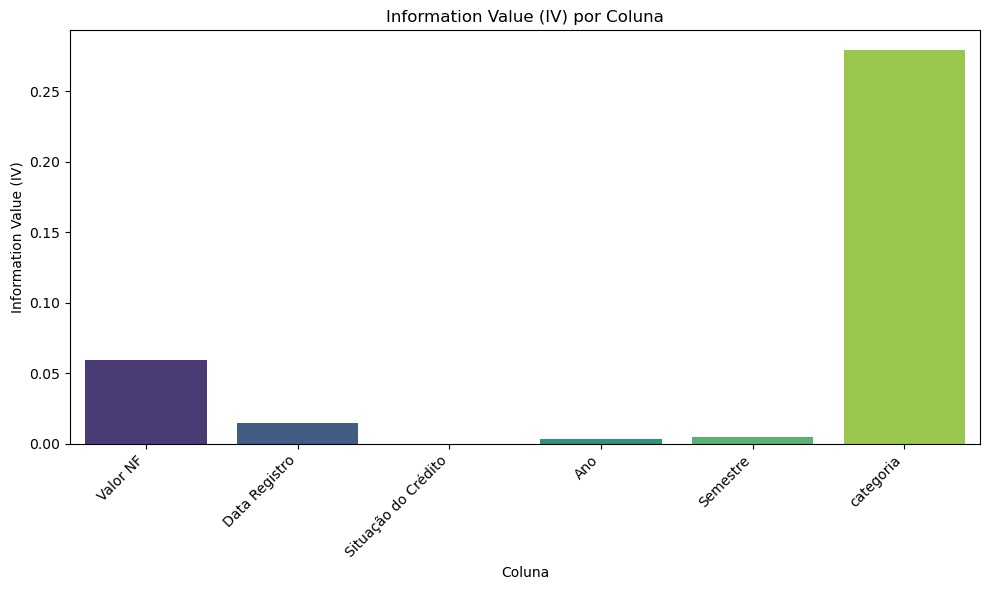

In [21]:
# Dimensões
plt.figure(figsize=(10, 6))

# Tipo barplot, usando as chaves no X e os valores no Y do dicionário dic_IV criado no looping anterior
sns.barplot(x=list(dic_IV.keys()), y=list(dic_IV.values()), palette='viridis')
plt.title('Information Value (IV) por Coluna')
plt.xlabel('Coluna')
plt.ylabel('Information Value (IV)')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos do eixo x para melhor visualização
plt.tight_layout()
plt.show()

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

In [22]:
# Mostrando o número exato de IV para cada coluna
dic_IV

{'Valor NF': 0.05915536491528853,
 'Data Registro': 0.014371002055518018,
 'Situação do Crédito': 2.7401818308515266e-05,
 'Ano': 0.0031679751375377958,
 'Semestre': 0.004906429155148823,
 'categoria': 0.27907087937795494}

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
#### Com toda certeza a coluna categoria é de longe a variável com maior poder de discriminação e ainda assim confiável de acordo com a tabela, a coluna Valor NF ainda apresenta um InformationValue considerável e os demais tem uma previsão muito fraca.
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?
#### Sim, há uma relação que ao aumentar a quantidade de categorias pode aumentar o valor de IV, porém há um ponto ótimo que se ultrapassado pode começar a diminuir o IV. 

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

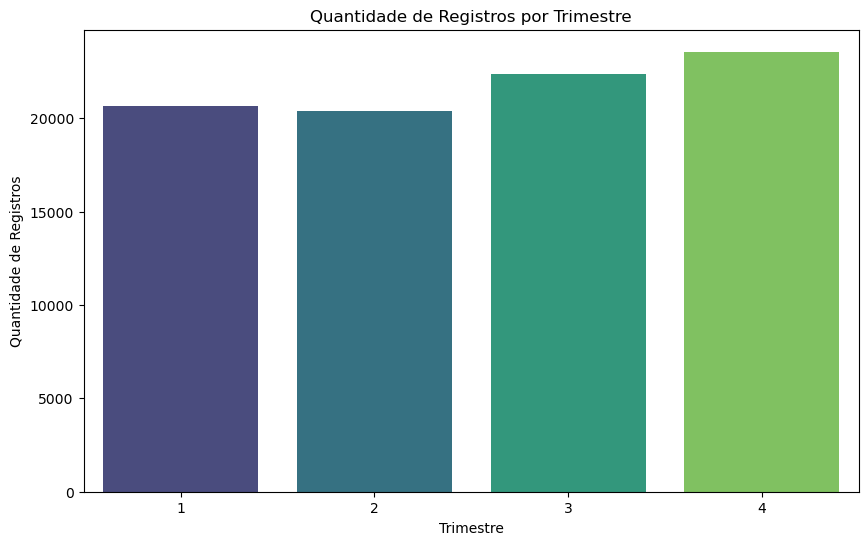

In [23]:
# Agrupado a quantidade de registros por trimestre, size faz a contagem mas modifica a coluna para indice
# Usado o reset_index para fazer o Trimestre a voltar a ser coluna.
registros_trimestre = df_data.groupby('Trimestre').size().reset_index(name='Quantidade')

plt.figure(figsize=(10, 6))
sns.barplot(data=registros_trimestre, x='Trimestre', y='Quantidade', palette='viridis')
plt.title('Quantidade de Registros por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Registros')
plt.show()

In [24]:
''' Criando o agrupamento de Trimestre e categoria e usando o size para calcular a quantidade de individuos
 de cada grupo.
 Quando usado o size() as colunas passam a ser multi-indices, ao usar o reset_index elas deixam de ser
indices e voltam a ser colunas e passado uma nova coluna para guardar a contagem dos valores'''
registros_trimestre_categoria = df_data.groupby(['Trimestre', 'categoria']).size().reset_index(name='Quantidade')
registros_trimestre_categoria

,Trimestre,categoria,Quantidade
0,1,Alimentos,1279
1,1,Auto posto,151
2,1,Construção,3853
3,1,Farmácia,2429
4,1,Mercado,6725
5,1,Restaurantes,753
6,1,Varejo,949
7,1,Vestuário,429
8,1,não definido,4087
9,2,Alimentos,1167


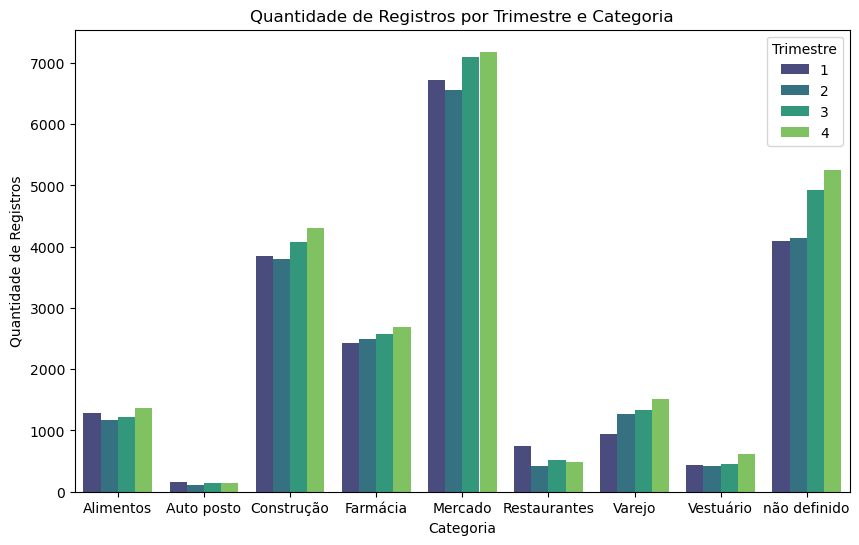

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(data=registros_trimestre_categoria, x='categoria', y='Quantidade', hue='Trimestre', palette='viridis')
plt.title('Quantidade de Registros por Trimestre e Categoria')
plt.xlabel('Categoria')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Trimestre')
plt.show()

In [26]:
# Separando os créditos positivos
creditos_positivos = df_data[df_data['flag_credito']==1]

# Fazendo dois agrupamentos iguais de Trimestre e categoria, porém o primeiro agrupamento contem apenas
# os valores com créditos positivos para dividir pelo segundo data frame que tem todos valores
# o reset_index precisa estar fora do parenteses da conta
proporcao_creditos_positivos = (creditos_positivos.groupby(['Trimestre', 'categoria']).size() / df_data.groupby(['Trimestre', 'categoria']).size()).reset_index(name='Proporção')
proporcao_creditos_positivos

,Trimestre,categoria,Proporção
0,1,Alimentos,0.709930
1,1,Auto posto,0.225166
2,1,Construção,0.470023
3,1,Farmácia,0.262660
4,1,Mercado,0.486394
5,1,Restaurantes,0.783533
6,1,Varejo,0.181243
7,1,Vestuário,0.268065
8,1,não definido,0.393198
9,2,Alimentos,0.630677


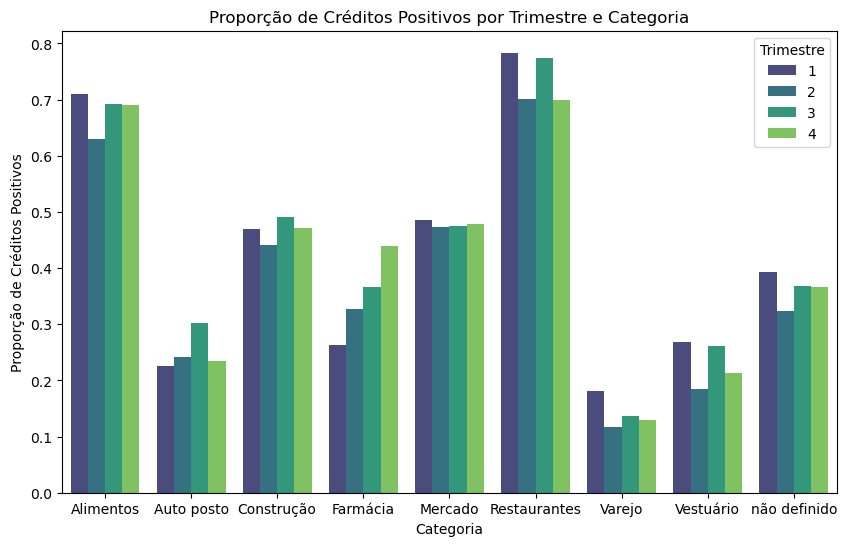

In [27]:
# Plotando o gráfico de barras da proporção de créditos positivos
plt.figure(figsize=(10, 6))
sns.barplot(data=proporcao_creditos_positivos, x='categoria', y='Proporção', hue='Trimestre', palette='viridis')
plt.title('Proporção de Créditos Positivos por Trimestre e Categoria')
plt.xlabel('Categoria')
plt.ylabel('Proporção de Créditos Positivos')
plt.legend(title='Trimestre')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

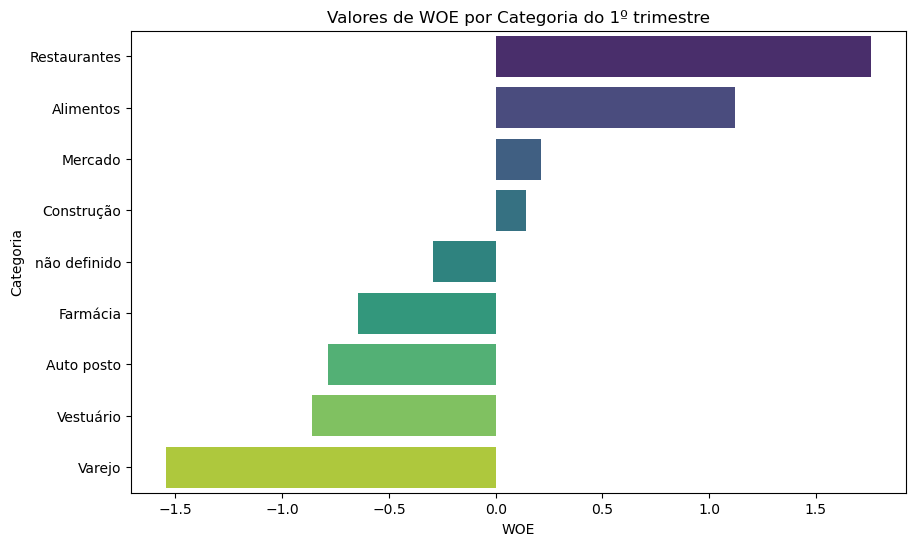

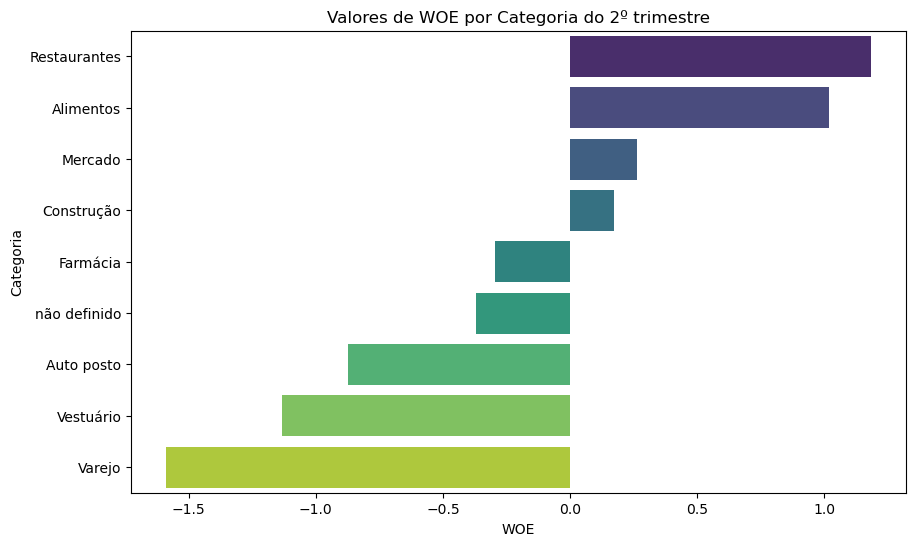

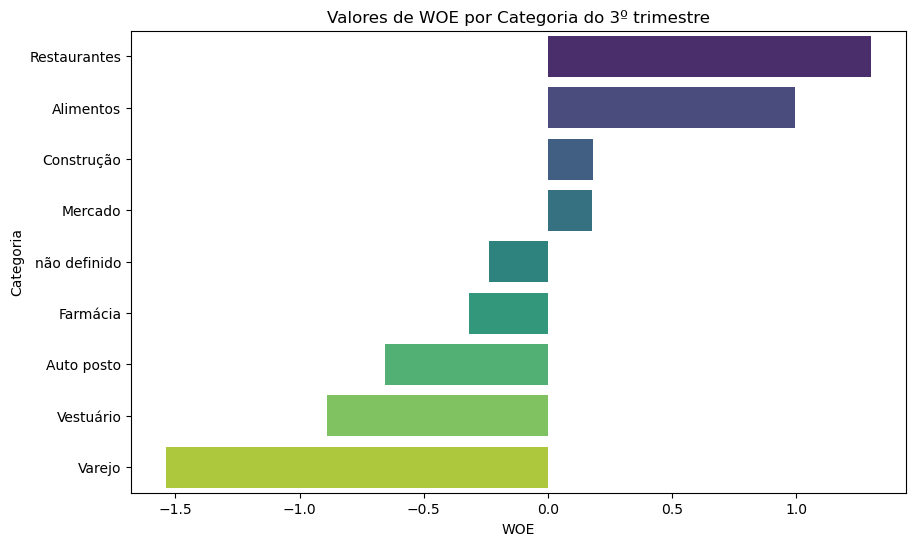

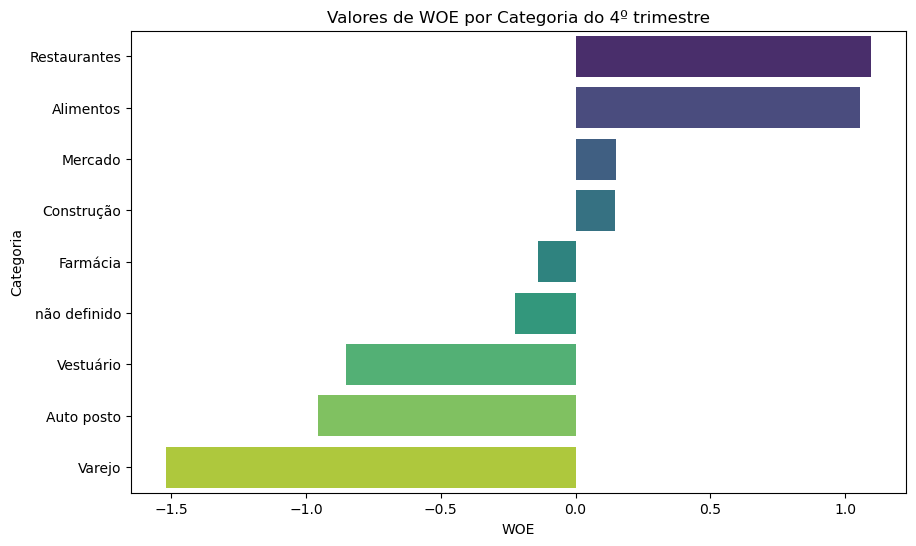

In [66]:
# Criando um DF apenas para salvar as colunas a serem usadas
df_categoria_trimestral = df_data[['Trimestre', 'flag_credito', 'categoria']]

# Separando os valores em evento e não evento
df_evento = df_categoria_trimestral[df_categoria_trimestral['flag_credito']==1]
df_no_evento = df_categoria_trimestral[df_categoria_trimestral['flag_credito']==0]
# Removendo a variável resposta flag_credito para o calculo do IV não iterar sobre essa coluna
df_categoria_trimestral = df_categoria_trimestral.drop(columns=['flag_credito'])

# Criando os dicionários para salvar os valores de IV
dic_IV_trimestral = {}
# Criando dicionário para salvar em chave o trimestre e o valor o DataFrame inteiro
dic_dfs_trimestral = {}

# Esse for itera em cada semestre de forma crescente
for trimestre in sorted(df_categoria_trimestral['Trimestre'].unique()):
    
    # Cria dois DataFrames para evento e não evento, salvando apenas o trimestre em questão
    df_evento_trimestral = df_evento[df_evento['Trimestre'] == trimestre]
    df_no_evento_trimestral = df_no_evento[df_no_evento['Trimestre'] == trimestre]
    
    # Salvando a quantidade de valores de cada categoria da coluna
    contagem_categorias_1 = df_evento_trimestral['categoria'].value_counts()
    contagem_categorias_0 = df_no_evento['categoria'].value_counts()
    
    # Reindexar contagem_categorias_1 com base nos índices de contagem_categorias_0 para ficarem iguais
    contagem_categorias_1 = contagem_categorias_1.reindex(contagem_categorias_0.index, fill_value=0)
    
    # Criando um DataFrame combinando os dois panda series acima
    # O passo para ordenar com base em um dos indices anteriormente é importante agora
    # para que a ordem das categorias sejam as mesmas
    df_table_stats = pd.DataFrame({coluna: contagem_categorias_0.index,
                   '0': contagem_categorias_0.values,
                   '1': contagem_categorias_1.values})
    
    # Criando  COLUNA total, que é  soma da coluna 0 e 1
    df_table_stats['total'] = df_table_stats['0'] + df_table_stats['1']

    # Calcular o total para as colunas '0', '1' e 'total' para incluir na 
    # criação da LINHA total
    total_0 = df_table_stats['0'].sum()
    total_1 = df_table_stats['1'].sum()
    total = df_table_stats['total'].sum()
    # Usado o .loc para criar uma LINHA ao invés de uma coluna
    df_table_stats.loc['total'] = ['Total', total_0, total_1, total]
    
    # Criando a coluna pct_0, que é a porcentagem da coluna 0 pelo seu total
    df_table_stats['pct_0'] = df_table_stats['0'] / df_table_stats.loc['total', '0']

    # Criando a coluna pct_1, que é a porcentagem da coluna 1 pelo seu total
    df_table_stats['pct_1'] = df_table_stats['1'] / df_table_stats.loc['total', '1']

    # Criando a coluna razão de chance, que é a porcentagem do evento dividido pela porcentagem de não evento
    df_table_stats['rc'] = df_table_stats['pct_1'] / df_table_stats['pct_0']

    # Criando a coluna weight of evidence, que é o logaritimo da divisão das porcentagens de evento e não evento
    df_table_stats['woe'] = np.log(df_table_stats['rc'])
    
    # Calculando o information value parcial de cada categoria
    df_table_stats['iv_parcial'] = df_table_stats['woe'] * (df_table_stats['pct_1'] - df_table_stats['pct_0'])
    
    # Removendo a linha total para não aparecer no gráfico
    df_table_stats = df_table_stats.drop(index='total')
    
    # Adicionando ao dicionário o trimestre como chave e o total do IV como valor
    dic_IV_trimestral[trimestre] = df_table_stats['iv_parcial'].sum()
    # Adicionando ao dicionário o trimestre como chave e o DataFrame inteiro como valor
    dic_dfs_trimestral[trimestre] = df_table_stats
    
    # GRÁFICO de cada iteração (também da pra fazer usando o dicionário de dfs)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='woe', y='categoria', data=df_table_stats.sort_values(by='woe', ascending=False), palette='viridis')
    # Adicionando título e rótulos dos eixos
    plt.title(f'Valores de WOE por Categoria do {trimestre}º trimestre')
    plt.xlabel('WOE')
    plt.ylabel('Categoria')
    # Mostrando o gráfico
    plt.show()

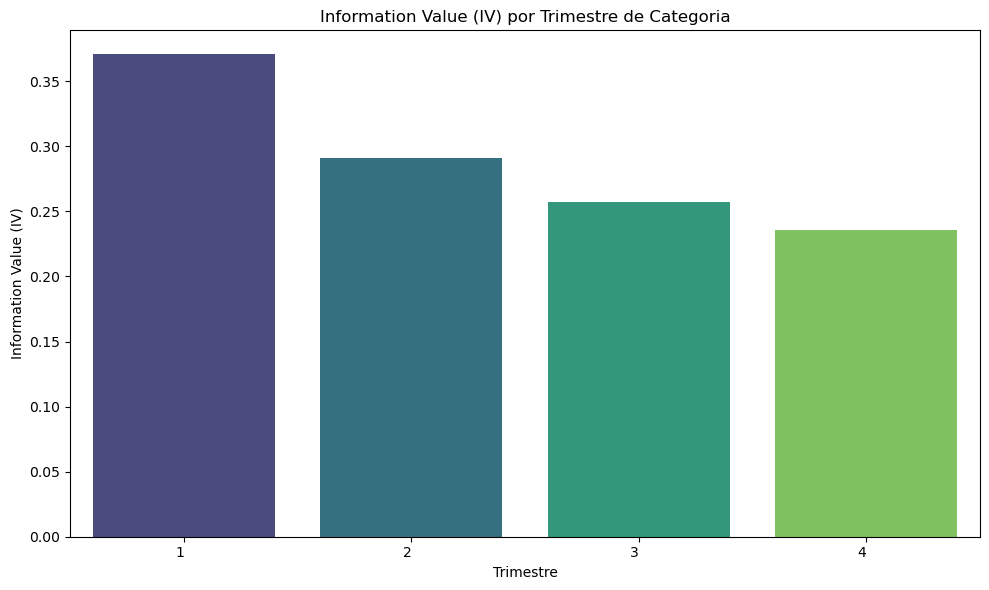

In [67]:
# Dimensões
plt.figure(figsize=(10, 6))

# Tipo barplot, usando as chaves no X e os valores no Y do dicionário dic_IV criado no looping anterior
sns.barplot(x=list(dic_IV_trimestral.keys()), y=list(dic_IV_trimestral.values()), palette='viridis')
plt.title('Information Value (IV) por Trimestre de Categoria')
plt.xlabel('Trimestre')
plt.ylabel('Information Value (IV)')
plt.xticks(ha='right')  # Rotacionar os rótulos do eixo x para melhor visualização
plt.tight_layout()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

#### Ao decorrer dos trimestres os valores de WOE de cada categoria se aproxima e isso faz com que o IV descresça um pouco, mas ainda com muita relevância. As categorias que mais trazem informação são Varejo e Restaurantes, sendo Restaurantes a categoria que mais trás informação para notas com retorno maiores que zero e Varejo seria o contrário.
<br>

#### Respondendo as perguntas:
#### As categorias que tem maior proporção de notas com retorno maiores que zero são Restaurantes e Alimentos, Mercado e Construção também ajudam, mas bem pouco se comparado.
<br>

#### As diferenças são estáveis ao longo do tempo, com algumas mudanças pequenas que fazem que uma categoria seja melhor ou pior que a outra caso elas já tenham um resultado similar, mas no geral as categorias se mantem.